In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
train_len = 36481
valid_len = 7817
window_len = 12 + 12 # 12 for history | 12 for future

# start_ts = datetime.fromisoformat('20170101T00:00:00')
start_ts = datetime.strptime('20170101T00:00:00', '%Y%m%dT%H:%M:%S')
timestamps = [start_ts + timedelta(minutes = 5 * train_len) + timedelta(minutes = 5 * i) for i in range(valid_len - window_len)]

In [3]:
data_folder = '../logs/2025-02-26_11-36-36_pems-bay_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric'
arr_A = np.genfromtxt(f'{data_folder}/d_original.csv', delimiter=',').T
arr_B = np.genfromtxt(f'{data_folder}/d_no_neighbours.csv', delimiter=',').T
arr_y = np.genfromtxt('../data/pems-bay/vel.csv', delimiter=',', skip_header = train_len+window_len-1, max_rows = valid_len-window_len).T
arr_A.shape, arr_B.shape, arr_y.shape

((325, 7793), (325, 7793), (325, 7793))

In [4]:
df = pd.DataFrame(arr_y).melt(var_name = 'timestep', value_name = 'y', ignore_index = False)
df['err_graph'] = pd.DataFrame(arr_A).melt().value
df['err_local'] = pd.DataFrame(arr_B).melt().value
df = df.reset_index(names = 'sensor')
df['timestamp'] = start_ts + timedelta(minutes=5 * train_len) + pd.to_timedelta(df.timestep * 5, unit='m')
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

df_A = pd.DataFrame(arr_A, columns = timestamps).rename_axis(index = 'sensor')
df_B = pd.DataFrame(arr_B, columns = timestamps).rename_axis(index = 'sensor')

In [6]:
selected_sensors = [133, 134, 320, 74, 283]
selected_sensors = [134]

subset_df_A = df_A.loc[selected_sensors]
subset_df_B = df_B.loc[selected_sensors]
subset_df = df[df['sensor'].isin(selected_sensors)]
df_y = pd.DataFrame(arr_y, columns=timestamps).rename_axis(index='sensor')

()

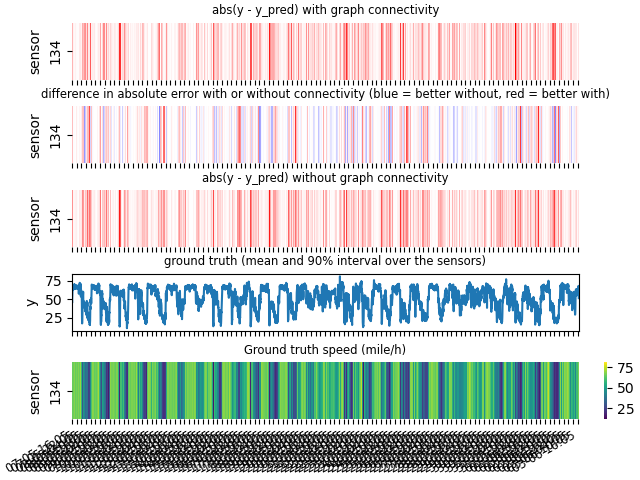

In [9]:
df_y = pd.DataFrame(arr_y, columns=timestamps).rename_axis(index='sensor')

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex = True, layout = 'constrained')
ax1.set_title('abs(y - y_pred) with graph connectivity', size = 'small')
sns.heatmap(subset_df_A, cmap = 'bwr', ax = ax1, cbar = False, center = 0, rasterized = True)
ax2.set_title('difference in absolute error with or without connectivity (blue = better without, red = better with)', size = 'small')
sns.heatmap(subset_df_B - subset_df_A, cmap = 'bwr', ax = ax2, cbar = False, center = 0, rasterized = True)
ax3.set_title('abs(y - y_pred) without graph connectivity', size = 'small')
sns.heatmap(subset_df_B, cmap = 'bwr', ax = ax3, cbar = False, center = 0, rasterized = True)
ax4.set_title('ground truth (mean and 90% interval over the sensors)', size = 'small')
sns.lineplot(subset_df, x = 'timestep', y = 'y', errorbar = ('pi', 90), ax = ax4)
ax5.set_title('Ground truth speed (mile/h)', size='small')
sns.heatmap(df_y.loc[selected_sensors], cmap='viridis', ax=ax5, cbar=True, rasterized=True)
ax5.set_xticks(list(range(0, valid_len - window_len, 12*6)), [ts.strftime('%d-%m %H:%M') for ts in timestamps[::12*6]], rotation = 30, ha = 'right', size = 'small')
()

()

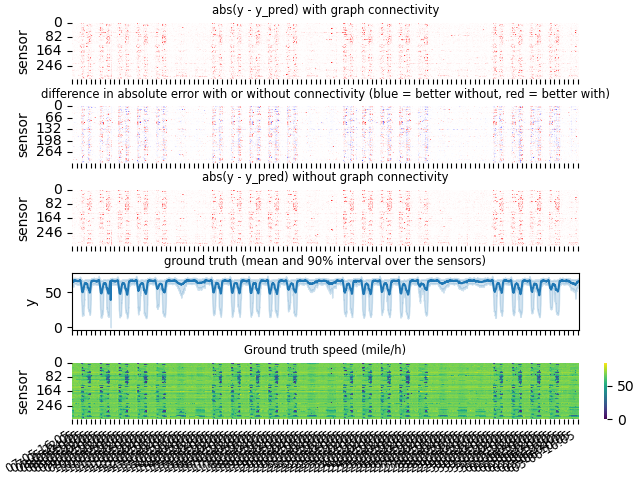

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex = True, layout = 'constrained')
ax1.set_title('abs(y - y_pred) with graph connectivity', size = 'small')
sns.heatmap(df_A, cmap = 'bwr', ax = ax1, cbar = False, center = 0, rasterized = True)
ax2.set_title('difference in absolute error with or without connectivity (blue = better without, red = better with)', size = 'small')
sns.heatmap(df_B - df_A, cmap = 'bwr', ax = ax2, cbar = False, center = 0, rasterized = True)
ax3.set_title('abs(y - y_pred) without graph connectivity', size = 'small')
sns.heatmap(df_B, cmap = 'bwr', ax = ax3, cbar = False, center = 0, rasterized = True)
ax4.set_title('ground truth (mean and 90% interval over the sensors)', size = 'small')
sns.lineplot(df, x = 'timestep', y = 'y', errorbar = ('pi', 90), ax = ax4)
ax5.set_title('Ground truth speed (mile/h)', size='small')
sns.heatmap(df_y, cmap='viridis', ax=ax5, cbar=True, rasterized=True)
ax5.set_xticks(list(range(0, valid_len - window_len, 12*6)), [ts.strftime('%d-%m %H:%M') for ts in timestamps[::12*6]], rotation = 30, ha = 'right', size = 'small')
()

In [8]:
from tslearn.clustering import TimeSeriesKMeans
num_clusters = 6
kmeans = TimeSeriesKMeans(num_clusters)
sensor_clusters = kmeans.fit_predict(arr_y)
df['sensor_cluster'] = sensor_clusters[df.sensor]
df.sensor_cluster.value_counts() / (valid_len - window_len)

ModuleNotFoundError: No module named 'tslearn'

In [10]:
sns.relplot(df, x = 'timestamp', y = 'y', errorbar = ('pi', 90), kind = 'line', col = 'sensor_cluster', col_wrap = 2)

ValueError: Could not interpret value `sensor_cluster` for `col`. An entry with this name does not appear in `data`.

In [42]:
from scipy.signal import find_peaks

# Load ground truth speed data (y)
def detect_dips(arr_y, timestamps, sensor_id, prominence=20):
    y_values = arr_y[sensor_id]
    
    # Find dips (local minima)
    dips, _ = find_peaks(-y_values, prominence=prominence)
    dip_times = [timestamps[i] for i in dips]
    dip_speeds = [y_values[i] for i in dips]
    
    return dips, dip_times, dip_speeds

def compare_errors_at_dips(dips, subset_df_A, subset_df_B, sensor_id=134):
    error_diffs = subset_df_B.loc[sensor_id] - subset_df_A.loc[sensor_id]  # Difference in error
    dip_errors = error_diffs.iloc[dips]  # Get error difference at dips

    # Boolean masks for dips where graph is better or worse
    better_with_graph_mask = dip_errors > 0
    better_without_graph_mask = dip_errors < 0

    # Get timestamps for better cases
    better_with_graph_timestamps = [dip_times[i] for i in range(len(dips)) if better_with_graph_mask.iloc[i]]
    better_without_graph_timestamps = [dip_times[i] for i in range(len(dips)) if better_without_graph_mask.iloc[i]]

    avg_error_improvement = dip_errors.mean()

    return dip_errors, better_with_graph_timestamps, better_without_graph_timestamps, avg_error_improvement

# Example usage
dips, dip_times, dip_speeds = detect_dips(arr_y, timestamps, 134)
dip_errors, better_with_graph_timestamps, better_without_graph_timestamps, avg_error_improvement = compare_errors_at_dips(
    dips, subset_df_A, subset_df_B
)

print(f"Total dips detected: {len(dips)}")
print(f"Dip times: {dip_times}")
print(f"dip_errors: {dip_errors}")
print(f"better_with_graph_timestamps {better_with_graph_timestamps}")
print(f"better_without_graph_timestamps {better_without_graph_timestamps}")
print(f"Average error difference at dips: {avg_error_improvement:.4f} (positive means graph is better)")

Total dips detected: 81
Dip times: [datetime.datetime(2017, 5, 8, 5, 0), datetime.datetime(2017, 5, 8, 14, 55), datetime.datetime(2017, 5, 9, 4, 55), datetime.datetime(2017, 5, 9, 12, 25), datetime.datetime(2017, 5, 9, 14, 10), datetime.datetime(2017, 5, 10, 5, 5), datetime.datetime(2017, 5, 10, 14, 25), datetime.datetime(2017, 5, 11, 4, 55), datetime.datetime(2017, 5, 11, 7, 25), datetime.datetime(2017, 5, 11, 14, 25), datetime.datetime(2017, 5, 12, 8, 35), datetime.datetime(2017, 5, 12, 15, 0), datetime.datetime(2017, 5, 13, 8, 15), datetime.datetime(2017, 5, 13, 13, 0), datetime.datetime(2017, 5, 14, 10, 25), datetime.datetime(2017, 5, 15, 5, 5), datetime.datetime(2017, 5, 15, 14, 45), datetime.datetime(2017, 5, 16, 4, 55), datetime.datetime(2017, 5, 16, 14, 50), datetime.datetime(2017, 5, 16, 22, 50), datetime.datetime(2017, 5, 17, 4, 55), datetime.datetime(2017, 5, 17, 14, 50), datetime.datetime(2017, 5, 18, 5, 0), datetime.datetime(2017, 5, 18, 12, 40), datetime.datetime(2017, 5,

KeyError: "None of [Index([134], dtype='int64')] are in the [index]"

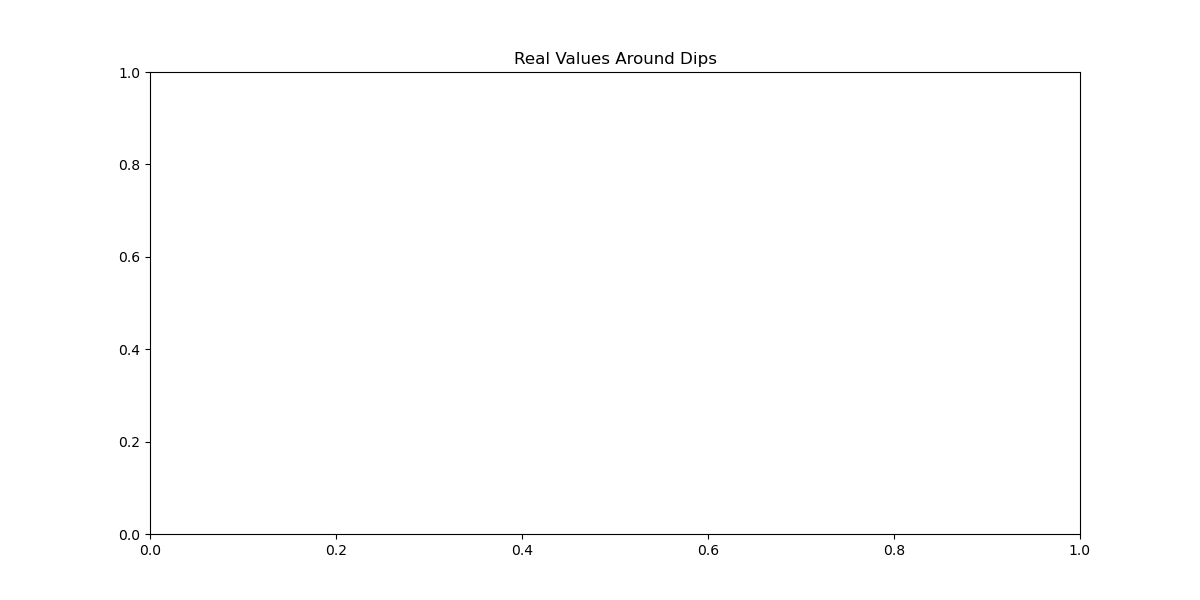

In [ ]:
# Extract relevant timestamps (dips ± 24 timesteps)
time_window = 24  # ±24 timesteps

dip_indices = [timestamps.index(dip) for dip in dip_times]

selected_timestamps = []
for idx in dip_indices:
    start = max(0, idx - time_window)
    end = min(len(timestamps), idx + time_window + 1)
    selected_timestamps.extend(timestamps[start:end])

# Convert set to sorted list
selected_timestamps = sorted(set(selected_timestamps))

df_selected = df[pd.to_datetime(df['timestamp']).isin(selected_timestamps)]

tick_positions = list(range(0, len(selected_timestamps) - window_len, 12*6))
tick_labels = [ts.strftime('%d-%m %H:%M') for ts in selected_timestamps[::12*6]]

# Ensure they have the same length
min_length = min(len(tick_positions), len(tick_labels))
tick_positions = tick_positions[:min_length]
tick_labels = tick_labels[:min_length]

# Plot real values with Seaborn
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Real Values Around Dips", fontsize=12)
sns.lineplot(data=df_selected, x="timestamp", y="y", errorbar=('pi', 90), ax=ax)
# ax.set_xticks(list(range(0, len(selected_timestamps) - window_len, 12*6)), [ts.strftime('%d-%m %H:%M') for ts in selected_timestamps[::12*6]], rotation = 30, ha = 'right', size = 'small')  # Show only dip times on x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize='small')
fig

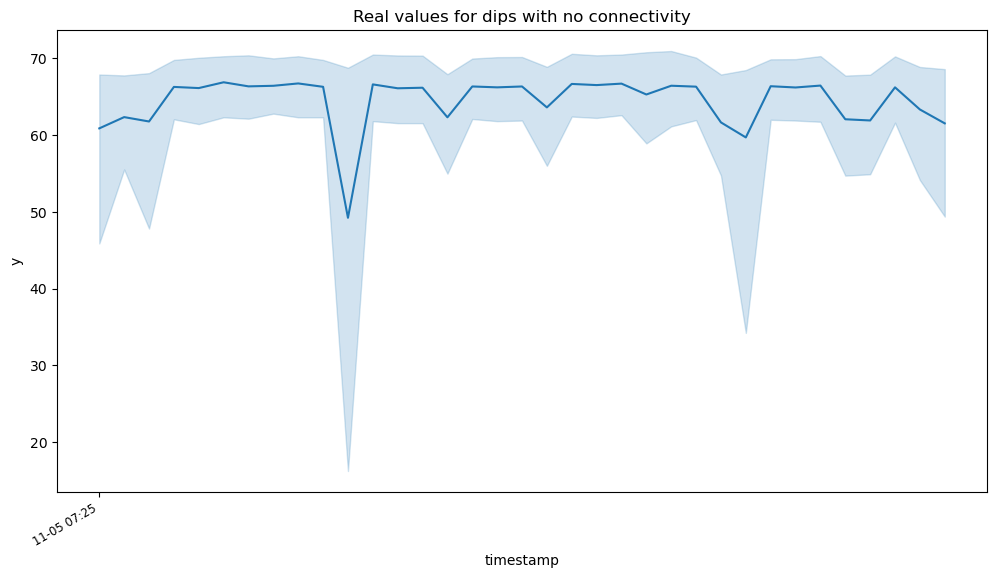

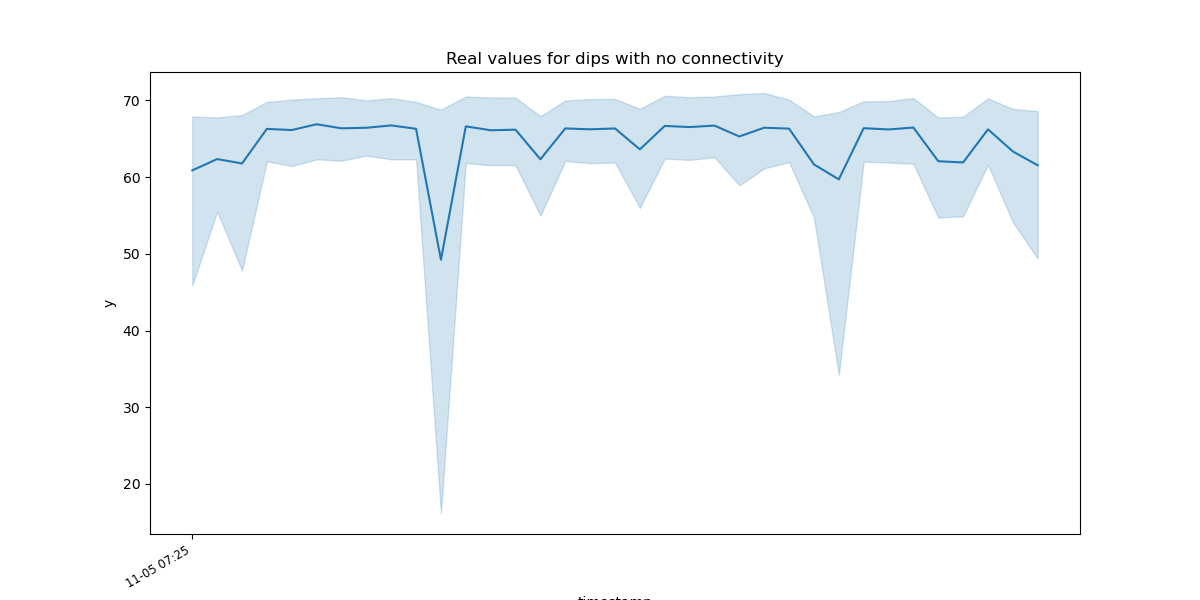

In [41]:
# Extract relevant timestamps (dips ± 24 timesteps)
time_window = 0  # ±24 timesteps

dip_indices = [timestamps.index(dip) for dip in better_without_graph_timestamps]

selected_timestamps = []
for idx in dip_indices:
    start = max(0, idx - time_window)
    end = min(len(timestamps), idx + time_window + 1)
    selected_timestamps.extend(timestamps[start:end])

# Convert set to sorted list
selected_timestamps = sorted(set(selected_timestamps))

df_selected = df[pd.to_datetime(df['timestamp']).isin(selected_timestamps)]

tick_positions = list(range(0, len(selected_timestamps) - window_len, 12*6))
tick_labels = [ts.strftime('%d-%m %H:%M') for ts in selected_timestamps[::12*6]]

# Ensure they have the same length
min_length = min(len(tick_positions), len(tick_labels))
tick_positions = tick_positions[:min_length]
tick_labels = tick_labels[:min_length]

# Plot real values with Seaborn
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Real values for dips with no connectivity", fontsize=12)
sns.lineplot(data=df_selected, x="timestamp", y="y", errorbar=('pi', 90), ax=ax)
# ax.set_xticks(list(range(0, len(selected_timestamps) - window_len, 12*6)), [ts.strftime('%d-%m %H:%M') for ts in selected_timestamps[::12*6]], rotation = 30, ha = 'right', size = 'small')  # Show only dip times on x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize='small')
fig

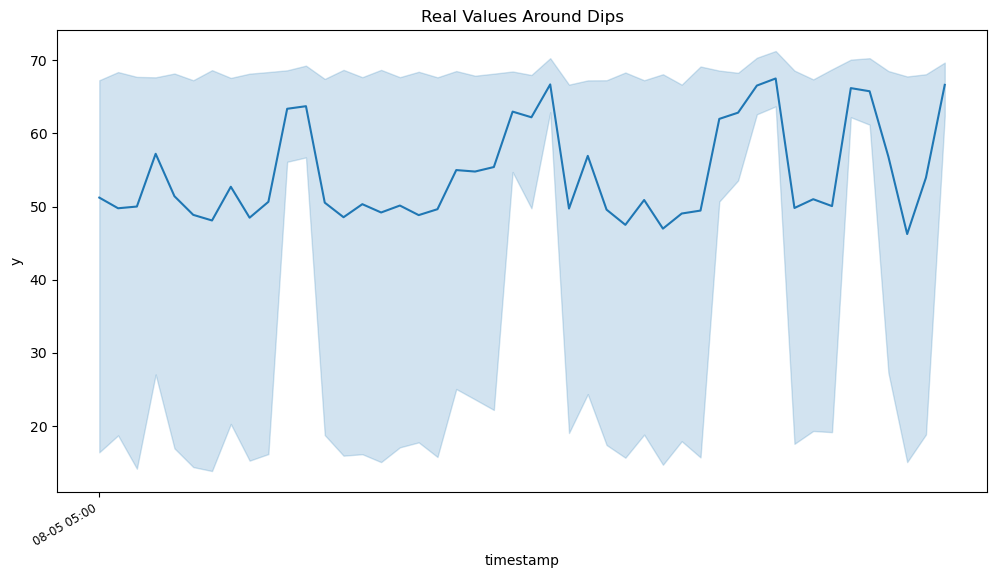

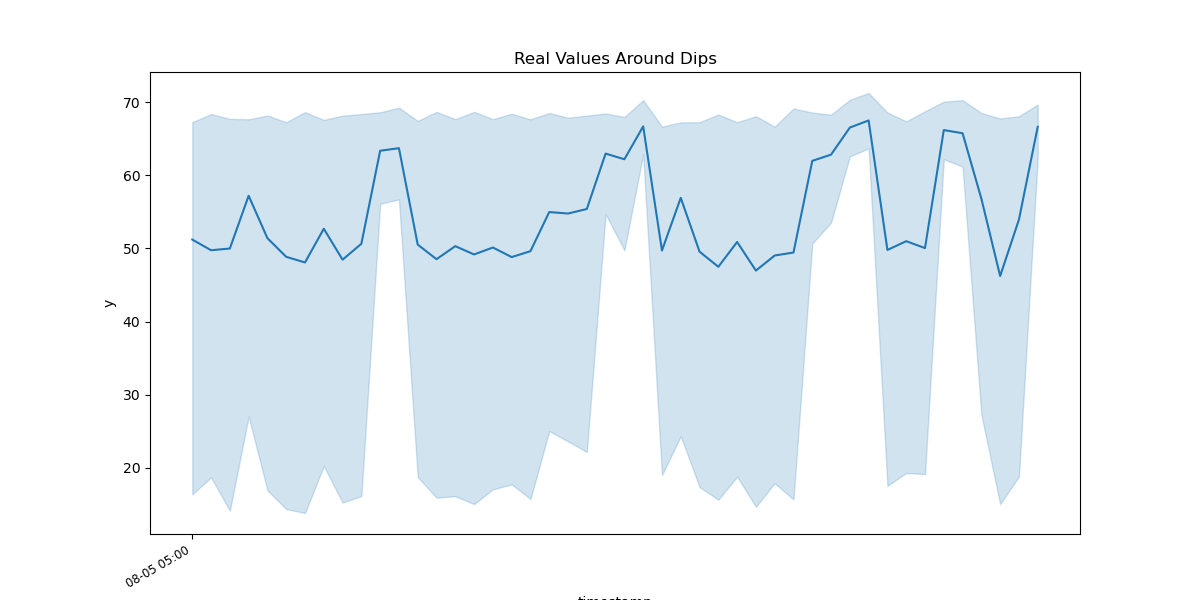

In [ ]:
# Extract relevant timestamps (dips ± 24 timesteps)
time_window = 0  # ±24 timesteps

dip_indices = [timestamps.index(dip) for dip in better_with_graph_timestamps]

selected_timestamps = []
for idx in dip_indices:
    start = max(0, idx - time_window)
    end = min(len(timestamps), idx + time_window + 1)
    selected_timestamps.extend(timestamps[start:end])

# Convert set to sorted list
selected_timestamps = sorted(set(selected_timestamps))

df_selected = df[pd.to_datetime(df['timestamp']).isin(selected_timestamps)]

tick_positions = list(range(0, len(selected_timestamps) - window_len, 12*6))
tick_labels = [ts.strftime('%d-%m %H:%M') for ts in selected_timestamps[::12*6]]

# Ensure they have the same length
min_length = min(len(tick_positions), len(tick_labels))
tick_positions = tick_positions[:min_length]
tick_labels = tick_labels[:min_length]

# Plot real values with Seaborn
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Real values for dips with connectivity", fontsize=12)
sns.lineplot(data=df_selected, x="timestamp", y="y", errorbar=('pi', 90), ax=ax)
# ax.set_xticks(list(range(0, len(selected_timestamps) - window_len, 12*6)), [ts.strftime('%d-%m %H:%M') for ts in selected_timestamps[::12*6]], rotation = 30, ha = 'right', size = 'small')  # Show only dip times on x-axis
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize='small')
fig

In [12]:
sensor_idx = 134
y_values = arr_y[sensor_idx]

# Detect dips (local minima in speed data)
inverted_y = -y_values  # Invert signal to find dips using `find_peaks`
dip_indices, properties = find_peaks(inverted_y, prominence=10)  # Detect dips with prominence at least 10 mph

# Extract errors at dip timestamps
errors_with_graph = arr_A[sensor_idx, dip_indices]  # Error with connectivity
errors_without_graph = arr_B[sensor_idx, dip_indices]  # Error without connectivity

# Compute average difference in error (negative means graph is better, positive means local is better)
error_diff = errors_without_graph - errors_with_graph
avg_error_diff = np.mean(error_diff)  # Average improvement

# Count dips where graph connectivity is better
graph_better_count = np.sum(error_diff > 0)
local_better_count = np.sum(error_diff < 0)

# Output results
len(dip_indices), avg_error_diff, graph_better_count, local_better_count


(220, np.float64(1.435543883930553), np.int64(109), np.int64(111))